На дипломном проекте "Нейросетевой кластерный анализ данных проточной цитофлуориметрии клеток крови человека" (защитила в августе 2023 года, Университет искусственного интеллекта), я работала с шикарным датасетом. Он настолько хорош, что было бы расточительством не использовать его в тренировке и в дальнейшем.

ДАТАСЕТ ЗАМЕЧАТЕЛЕН ТЕМ, ЧТО ОН:

- содержит реальные данные, которые использовались в научных исследованиях сотрудниками физфака МГУ для публикации ряда статей в ведущих научных изданиях, в том числе международных

- касается темы медицины, что всегда  интересно

- относительно большой по размеру - 150 тыс. позиций (кроме того, у меня есть версия на 4 млн позиций, может, ее тоже задействую, если компа хватит)

- размечен по 7 категориям, а значит, можно при применении обучения без учителя проверять качество работы

- сложный! так как:
  - не распределен нормально
  - категории несбалансированы, разница между количеством элементов в минимальном классе (50 элементов) и максимальном (129 тыс элементов) составляет 5 порядков
  - и несбалансированность классов нельзя "исправлять" аугументацией или синтетическими данными, так как может измениться клиника этих кадров данных крови. Тот случай, когда выбросы не стоит удалять, так как они не выбросы - а аномалии, влияющие на точность постановки диагноза.

Вот такой милый датасет. Кажется, что в нем собраны все возможные неприятности. Но это и интересно - для исследований.
  


**Подготовка несбалансированного датасета к нейросетевому кластерному анализу**

Нейросетевой кластерный анализ относится к типу обучение без учителя. Так что его задача - провести кластеризацию элементов разных категорий на основе признаков этих элементов, а не лейблов.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import math
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import seaborn as sns

from scipy import stats
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import gaussian_kde
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image, display
import matplotlib.animation as animation
%matplotlib inline

import warnings # подавляет все предупреждения о будущих изменениях
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [ ]:
dataset_original = pd.read_csv('/content/drive/MyDrive/data_to_train.csv')
dataset_original

,FSC-H,FSC-A,SSC-H,SSC-A,Violet SSC-H,Violet SSC-A,FITC-H,FITC-A,PE-H,PE-A,...,PB450-H,PB450-A,KO525-H,KO525-A,Violet660-H,Violet660-A,Violet780-H,Violet780-A,FSC-Width,label
0,487781,955439,125400,223558,444367,831804,837,1065,1055,1467,...,750,339,663,478,290,269,276,100,2005,RBC
1,495527,575362,72463,80871,230970,316030,518,-56,500,386,...,774,477,311,101,292,14,264,-250,1188,RBC
2,116544,111296,19778,18634,146147,181768,329,231,304,159,...,277,-154,410,-138,287,34,230,-44,977,Platelets and Debris
3,527017,578684,83965,88795,259432,345164,536,444,675,580,...,349,274,281,-6,401,130,263,291,1124,RBC
4,372142,517982,63586,83156,228285,384994,573,176,633,673,...,546,411,508,207,275,22,265,-62,1425,RBC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,413624,625629,79885,124630,292732,486821,483,502,586,375,...,453,-48,380,210,177,-132,262,-63,1548,RBC
149996,450344,569392,55193,64461,223109,375923,624,746,941,963,...,628,707,497,178,395,512,384,310,1294,RBC
149997,470545,577973,93735,111212,268047,384848,366,151,402,117,...,310,-123,424,59,216,7,193,-45,1257,RBC
149998,494760,688620,87414,116448,297315,456995,679,700,603,472,...,480,175,484,203,302,28,321,149,1425,RBC


In [ ]:
# Количество элементов в каждой категории
# датасет несбалансирован

category_counts = dataset_original['label'].value_counts().reset_index()
category_counts.columns = ['Категории', 'Количество элементов']
category_counts

,Категории,Количество элементов
0,RBC,129343
1,Platelets and Debris,15770
2,Granulocytes,2043
3,Lymphocytes,1396
4,EryPCs,889
5,Monocytes,509
6,Eosinophils,50


Я уже знаю, что датасет технически обработан - в нем нет пропусков, но имеются отрицательные и нулевые значения. Однако гораздо важнее сейчас то, что в датасете есть "парные" столбцы, и они сильно коррелируют друг с другом. Для последующего анализа признаков это может помешать - высокая коллениарность часто приводит к переобучению нейросети.

Между тем, графики Матрица корреляции и Коэффициент корреляции Пирсона  демонстрируют, что у всех признаков как раз и наблюдается сильная линейная зависимость, что указывает на их высокую положительную корреляцию  (r≈1).


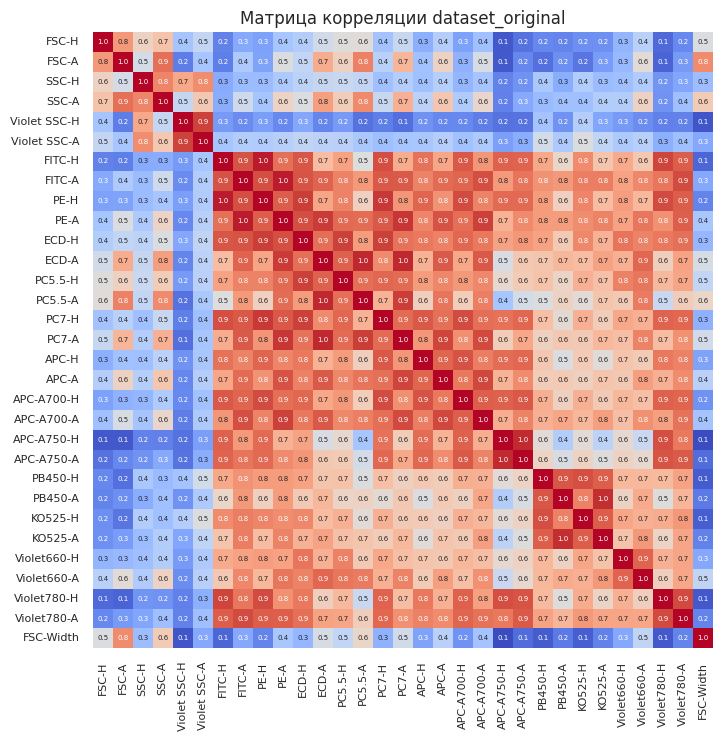

In [ ]:
# Матрица корреляции

corr_matrix = dataset_original.corr(numeric_only=True)
sns.set(rc={'figure.figsize':(8, 8)})
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.1f', annot_kws={"fontsize": 5}, cbar=False)
plt.title('Матрица корреляции dataset_original', fontsize=12)
plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
plt.show()

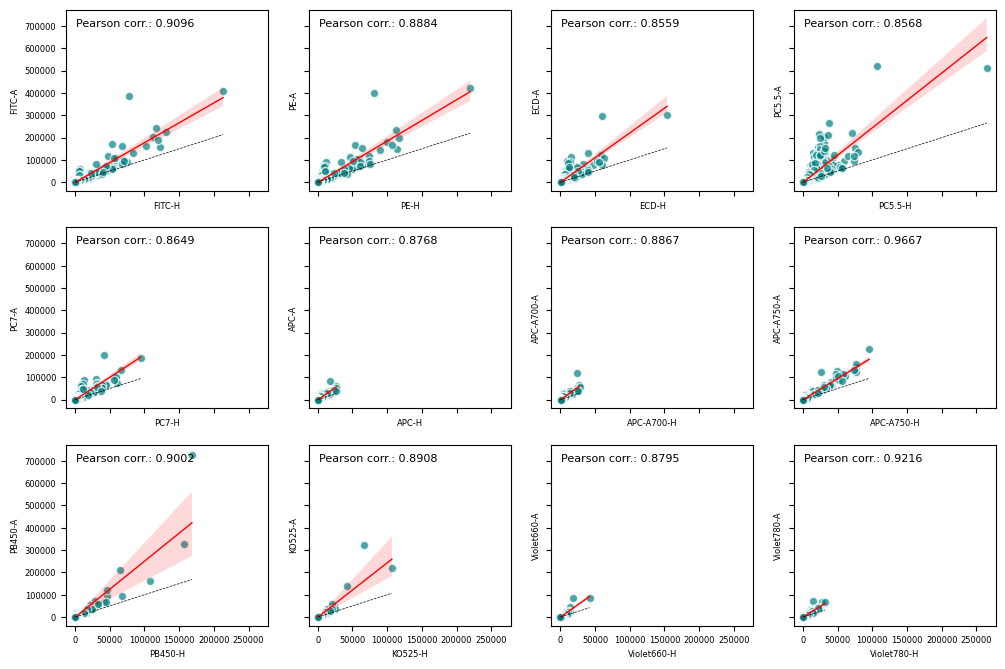

In [ ]:
# Визуализация Коффициента корреляции Пирсона

def corr_Pirs(z):
  def plot_distribution_line(ax, data):
      x_min = data.min()
      x_max = data.max()
      y_min = data.min()
      y_max = data.max()
      ax.plot([x_min, x_max], [y_min, y_max], linewidth=0.5, color='black', linestyle='--')
  fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(12, 8))
  fig.subplots_adjust(hspace=0.2)
  list_cols = [['FITC-H', 'FITC-A'], ['PE-H', 'PE-A'], ['ECD-H', 'ECD-A'], ['PC5.5-H', 'PC5.5-A'],
              ['PC7-H', 'PC7-A'], ['APC-H', 'APC-A'], ['APC-A700-H', 'APC-A700-A'], ['APC-A750-H', 'APC-A750-A'],
              ['PB450-H', 'PB450-A'], ['KO525-H', 'KO525-A'], ['Violet660-H', 'Violet660-A'], ['Violet780-H', 'Violet780-A']]
  for i, cols in enumerate(list_cols):
      row = i // 4
      col = i % 4

      corr, _ = pearsonr(z[cols[0]], z[cols[1]])
      sns.regplot(x=cols[0], y=cols[1], data=z, ax=axes[row, col],
                  color='teal', scatter_kws={'alpha': 0.7}, line_kws={'color': 'red', 'linewidth': 1})
      axes[row, col].annotate("Pearson corr.: {:.4f}".format(corr), xy=(0.05, 0.95),
                              xycoords='axes fraction', fontsize=8, ha='left', va='top')
      axes[row, col].set_xlabel(cols[0], fontsize=6)
      axes[row, col].set_ylabel(cols[1], fontsize=6)
      axes[row, col].tick_params(axis='both', labelsize=6)
      axes[row, col].collections[0].set_edgecolor("white")
      plot_distribution_line(axes[row, col], z[cols[0]])
  plt.show()

corr_Pirs(dataset_original)

Просто удалим столбцы с литерой -А. Далее удалим непризнаковые столбцы, оставив только колонки с информацией, полученной от взвеси клеток крови в момент прохождения ими луча лазера в оптической системе. Именно харатер оптического "отклика" в рамках проточной цирофлуoриметрии (ПЦ) того или иного типа лейкоцитов и прочих элементов крови является признаком, по которому этот элемент можно отнести к тому или иному типу лейкоцитов.    

In [ ]:
# Датасет до нормализации без столбцов с литерой -А

new_fullH_label = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_fullH_label.csv')
new_fullH_label.head(5)

,FSC-H,SSC-H,Violet SSC-H,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H,FSC-Width,label
0,487781,125400,444367,837,1055,951,2343,847,456,505,433,750,663,290,276,2005,RBC
1,495527,72463,230970,518,500,507,775,321,378,238,501,774,311,292,264,1188,RBC
2,116544,19778,146147,329,304,393,186,193,350,282,259,277,410,287,230,977,Platelets and Debris
3,527017,83965,259432,536,675,743,1225,306,621,351,217,349,281,401,263,1124,RBC
4,372142,63586,228285,573,633,917,1437,660,349,269,257,546,508,275,265,1425,RBC


На scatter plots  ниже также видна высокая корреляция между категориями и пространственное расположение категорий относительно друг друга.

Перевод графика в логарифмическую шкалу позволяет более наглядно и пропорционально визуализировать крайне несбалансированный датасет.

Хотя в данных ПЦ наибольший интерес представляют такие типы лейкоцитов, как Monocytes, Granulocytes и Lymphocytes, важны все остальные составляющие крови, включая и Platelets and Debris (клеточный мусор), и Eosinophils, которые имеют значение для иммунной системы. Именно эозонофилы составляют самую малочисленную группу. Во многих других ситуациях этот класс был бы удален из датасета, так как его можно счесть за выброс, серьезно осложняющий кластерный анализ. Но в случае с ПЦ, как было сказано выше, так поступать нельзя, поскольку может быть искажена клиническая картина.

Графики, отражающие самые плотные участки датасета, выделяют Monocytes, Granulocytes и Lymphocytes. Это подтверждает, что в целом данные визуализированы верно, поскольку:

- информация от лейкоцитов крови, полученная путем ПЦ, как правило имеет пространственные характеристики: Monocytes, Granulocytes и Lymphocytes плотно сбиты и располагаются кучно рядом друг с другом.
- остальные элементы не столь радикально зависимы от расположения, но этот факт как раз может усложнить различение того же клеточного мусора от эозонофилов или другой категории - ведь данные сильно коррелируют друг с другом по признаковой информации.

Экспоненциальный рост в случае кадра данных ПЦ означает увеличение числа клеток относительно своего признака в пробе. Для кластерного анализа это не имеет особого значения, но значимо для реальной диагностики.

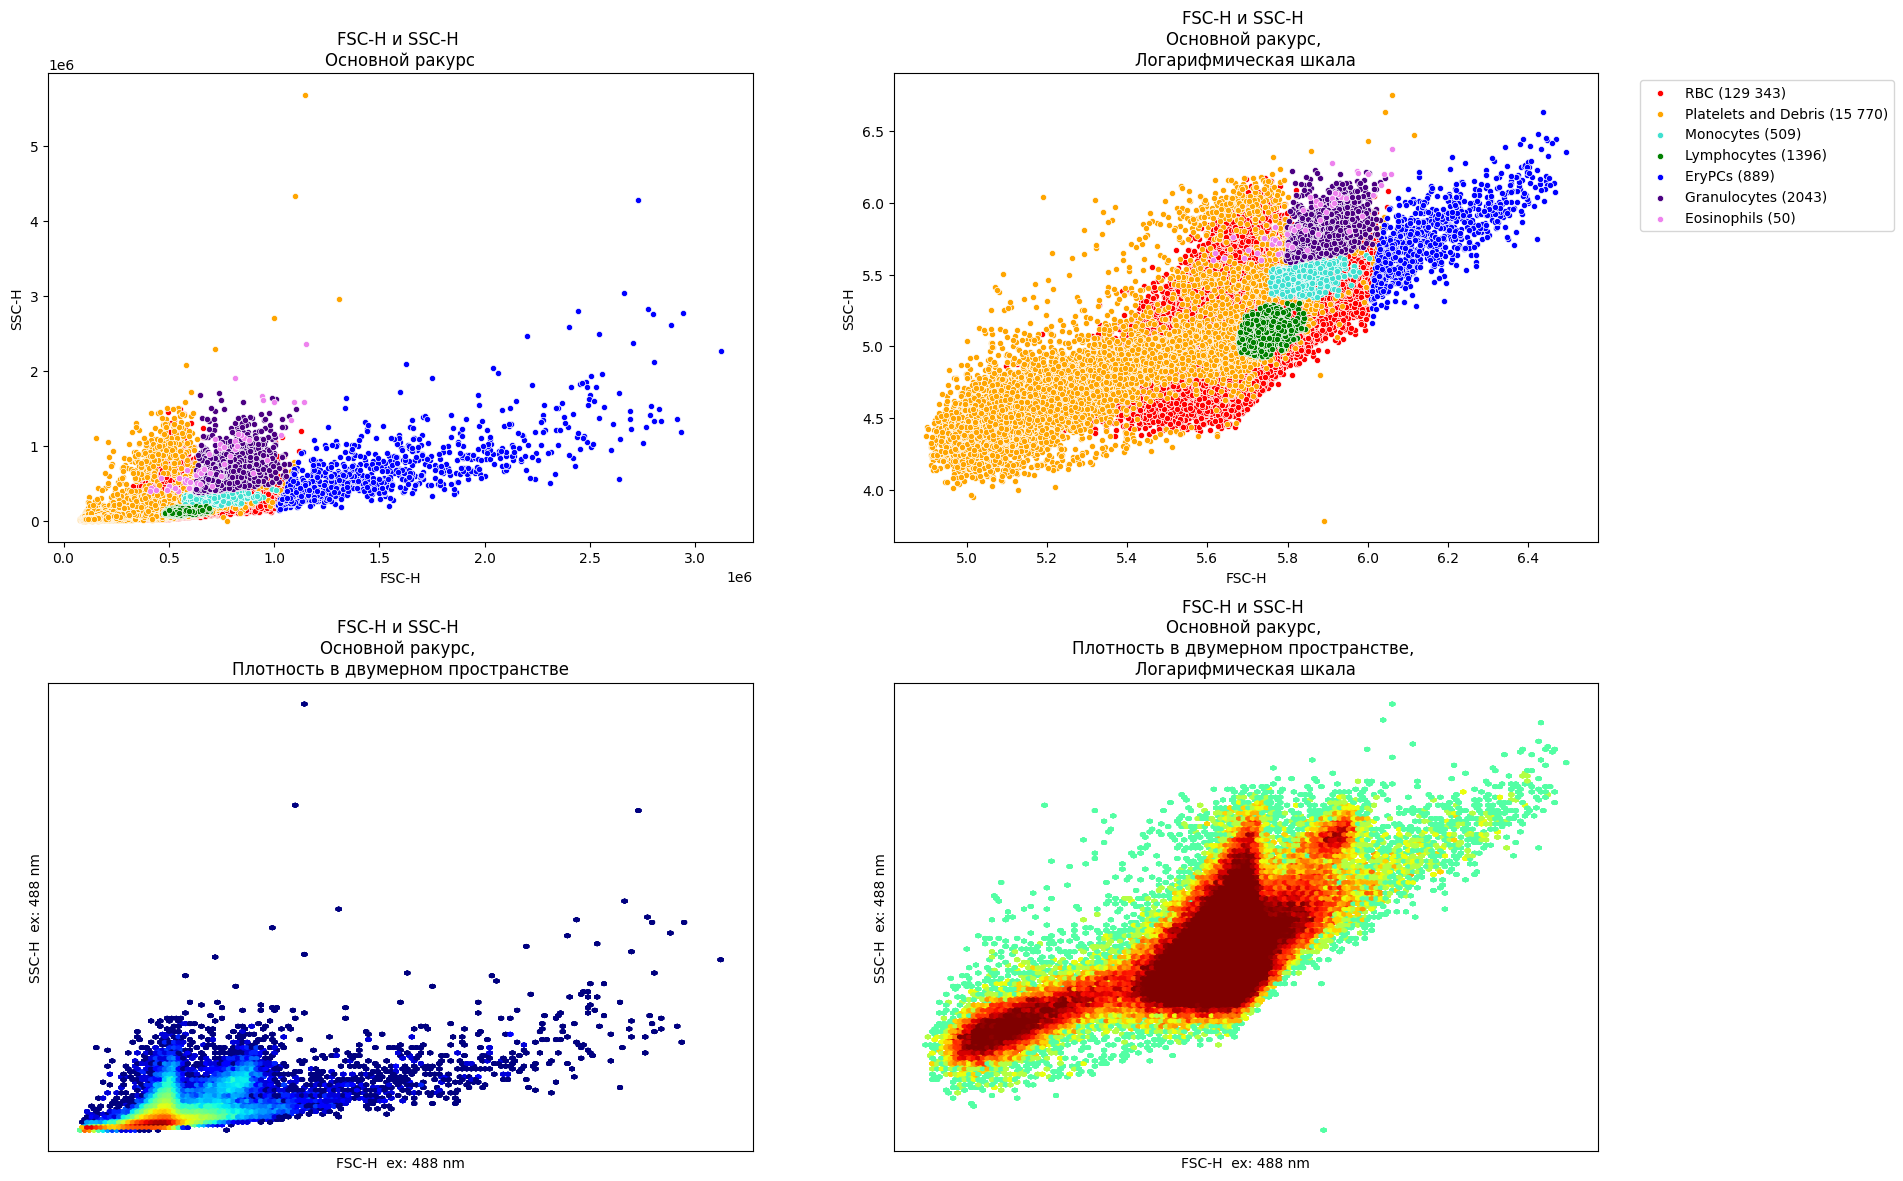

In [ ]:
# Функция вывода scatter-plot и hexbin + они же в логарифмической шкале

def log_histogram(dataset_fullH_label):
    fig, ax = plt.subplots(2, 2, figsize=(20, 14))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)

    datas = dataset_fullH_label

    datas['label'], _ = pd.factorize(datas['label'])
    label_dict = {0: 'RBC (129 343)', 1: 'Platelets and Debris (15 770)', 2: 'Monocytes (509)',
                  3: 'Lymphocytes (1396)', 4: 'EryPCs (889)', 5: 'Granulocytes (2043)', 6: 'Eosinophils (50)'}
    palette_custom = ['red', 'orange', 'turquoise', 'green', 'blue', 'indigo', 'violet']
    unique_list = np.unique(datas['label'])

    for category, color in zip(np.unique(datas['label']), palette_custom):
        category_data = datas[datas['label'] == category]
        scatter = ax[0, 0].scatter(category_data[datas['FSC-H'].name],
                          category_data[datas['SSC-H'].name],
                          c=[color], label=category, s=20, linewidth=0.5,
                          marker='o', edgecolor='white')
        ax[0, 0].set_title('FSC-H и SSC-H \nОсновной ракурс')
        ax[0, 0].set_xlabel('FSC-H')
        ax[0, 0].set_ylabel('SSC-H')
        ax[0, 0].tick_params(axis='x', labelsize=10)
        ax[0, 0].tick_params(axis='y', labelsize=10)

    for category, color in zip(np.unique(datas['label']), palette_custom):
        category_data = datas[datas['label'] == category]
        scatter = ax[0, 1].scatter(np.log10(category_data[datas['FSC-H'].name]),
                                np.log10(category_data[datas['SSC-H'].name]),
                                c=[color], label=category, s=20, linewidth=0.5,
                                marker='o', edgecolor='white')
        ax[0, 1].set_title('FSC-H и SSC-H \nОсновной ракурс, \nЛогарифмическая шкала')
        ax[0, 1].set_xlabel('FSC-H')
        ax[0, 1].set_ylabel('SSC-H')
        ax[0, 1].tick_params(axis='x', labelsize=10)
        ax[0, 1].tick_params(axis='y', labelsize=10)


        ax[1, 0].hexbin(datas['FSC-H'], datas['SSC-H'], bins=5900,
                     norm=mplcolors.LogNorm(), cmap=plt.cm.jet, gridsize=140)

        ax[1, 0].tick_params(axis='x', labelsize=10)
        ax[1, 0].tick_params(axis='y', labelsize=10)
        ax[1, 0].set_xlabel('FSC-H  ex: 488 nm')
        ax[1, 0].set_ylabel('SSC-H  ex: 488 nm')
        ax[1, 0].set_title('FSC-H и SSC-H \nОсновной ракурс, \nПлотность в двумерном пространстве')
        ax[1, 0].set_xticks([])
        ax[1, 0].set_xticklabels([])
        ax[1, 0].set_yticks([])
        ax[1, 0].set_yticklabels([])


        ax[1, 1].hexbin(np.log10(datas['FSC-H']), np.log10(datas['SSC-H']), bins=5900, norm=mplcolors.LogNorm(), cmap=plt.cm.jet, gridsize=140)
        ax[1, 1].tick_params(axis='x', labelsize=10)
        ax[1, 1].tick_params(axis='y', labelsize=10)
        ax[1, 1].set_xlabel('FSC-H  ex: 488 nm')
        ax[1, 1].set_ylabel('SSC-H  ex: 488 nm')
        ax[1, 1].set_title('FSC-H и SSC-H \nОсновной ракурс, \nПлотность в двумерном пространстве, \nЛогарифмическая шкала')
        ax[1, 1].set_xticks([])
        ax[1, 1].set_xticklabels([])
        ax[1, 1].set_yticks([])
        ax[1, 1].set_yticklabels([])

        handles, labels = ax[0, 1].get_legend_handles_labels()
        new_labels = [label_dict[int(label)] for label in labels]
        ax[0, 1].legend(handles, new_labels, bbox_to_anchor=(1.05, 1.0), fontsize=10)

    plt.show()

log_histogram(dataset_fullH_label)

In [ ]:
# Удаляем непризнаковые столбцы из датасета dataset_fullH_label
# Получаем рабочий ненормализованный датасет со столбцом label - new_opticalH_label

dat = new_fullH_label.drop(['FSC-H','SSC-H', 'Violet SSC-H', 'FSC-Width'], axis=1)
dat.to_csv('/content/drive/MyDrive/DIPLOM/new/new_opticalH_label.csv', index=False)
new_opticalH_label = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_opticalH_label.csv')

In [ ]:
new_opticalH_label.head(5)

,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H,label
0,837,1055,951,2343,847,456,505,433,750,663,290,276,RBC
1,518,500,507,775,321,378,238,501,774,311,292,264,RBC
2,329,304,393,186,193,350,282,259,277,410,287,230,Platelets and Debris
3,536,675,743,1225,306,621,351,217,349,281,401,263,RBC
4,573,633,917,1437,660,349,269,257,546,508,275,265,RBC


Для дальнейшей работы необходимо нормализовать данные. Однако выбирать способ преобразования следует в зависимости от типа распределения. Желательно, чтобы распределение оказалось близким к нормальному, хотя в реальных данных зачастую так не бывает.

Иными словами: нормальное распределение данных не является обязательным условием для работы нейросети, поскольку ее основная цель - на базе фактических данных обучиться и выстроить сложную функцию, способную к анализу и решению предиктивных задач as is.

Попросту нормальное распределение облегчает процесс обучения, так как обладает определенными математическими свойствами и отвечает известным статистическим закономерностям. Что и позволяет нейросети эффективнее находить зависимости в данных.





 Определим тип распределения вероятностей датасета ПЦ.  

 Для этого есть несколько визуальных и статистических инструментов:

 - гистограмма
 - Q-Q plot
 - Shapiro-Wilk Normality Test (но для больших датасетов свыше 2000 он ненадежен - не применяем)
 - Jarque Bera Test (как раз для больших данных), при p ≤ 0,05 распределение не считается нормальным. И др.


In [ ]:
# временно отсекаем столбец label

new_opticalH_label.iloc[:, :-1] = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_opticalH_label.csv')
df = new_opticalH_label.iloc[:, :-1]

In [ ]:
df.head(5)

,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H
0,837,1055,951,2343,847,456,505,433,750,663,290,276
1,518,500,507,775,321,378,238,501,774,311,292,264
2,329,304,393,186,193,350,282,259,277,410,287,230
3,536,675,743,1225,306,621,351,217,349,281,401,263
4,573,633,917,1437,660,349,269,257,546,508,275,265


In [ ]:
# Функция Гистограммы по столбцам

def histt(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
    distribution_name = 'Гистограммы'

    for i in range(len(df.columns)):
        column_data = df.iloc[:, i]
        row_index = i // 4
        col_index = i % 4
        if row_index < 3 and col_index < len(df.columns):
            n, bins, patches = ax[row_index, col_index].hist(column_data, bins=100,
                                                             alpha=0.9, color='darkgreen', density=True)

            mu, std = norm.fit(column_data)

            # Кривая нормального распределения
            xmin, xmax = column_data.min(), column_data.max()
            x = np.linspace(xmin, xmax, 100)
            y = norm.pdf(x, mu, std)
            ax[row_index, col_index].plot(x, y, 'r--', linewidth=1)
            ax[row_index, col_index].set_title(f"{df.columns[i]}", fontsize=8)

    fig.suptitle(distribution_name, fontsize=10)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for axi in ax.flat:
        axi.tick_params(axis='x', labelsize=8)
        axi.tick_params(axis='y', labelsize=8)
        axi.grid(color='grey', linestyle='-', linewidth=0.15)
        axi.set_facecolor('whitesmoke')

    plt.tight_layout()
    plt.show()

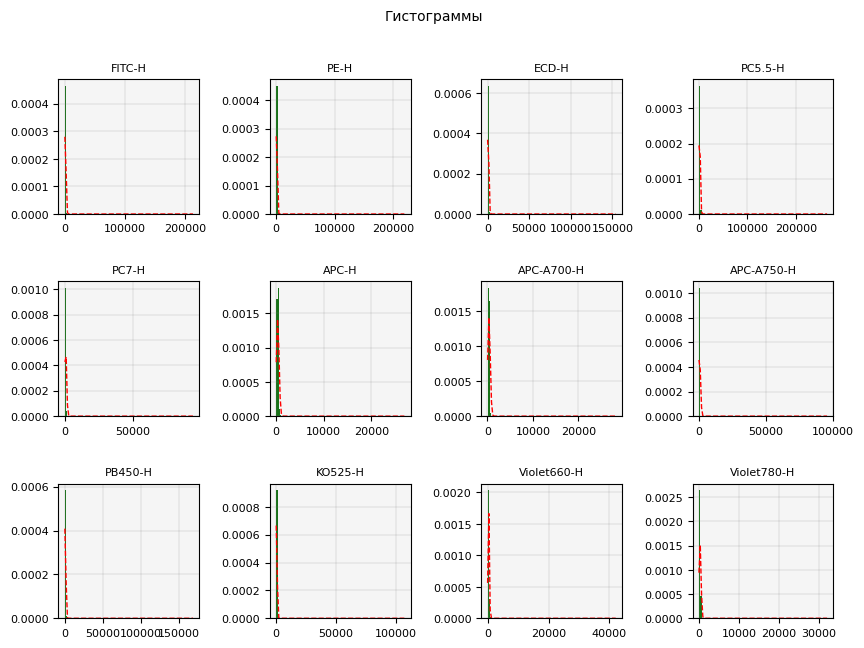

In [ ]:
histt(df)

In [ ]:
# Функция Q-Q plot

def qqplot(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
    distribution_name = 'Q-Q plot'

    for i, col in enumerate(df.columns):
        row_index = i // 4
        col_index = i % 4
        if row_index < 3 and col_index < len(df.columns):
            res = stats.probplot(df[col], plot=ax[row_index, col_index])
            ax[row_index, col_index].set_title(col, fontsize=10)
            ax[row_index, col_index].lines[0].set_linewidth(0.1)
            ax[row_index, col_index].set_title(f"{df.columns[i]}", fontsize=8)
            ax[row_index, col_index].set_xlabel('')
            ax[row_index, col_index].set_ylabel('')

    fig.suptitle(distribution_name, fontsize=10)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for axi in ax.flat:
        axi.tick_params(axis='x', labelsize=8)
        axi.tick_params(axis='y', labelsize=8)
        axi.grid(color='grey', linestyle='-', linewidth=0.15)
        axi.set_facecolor('whitesmoke')

    plt.tight_layout()
    plt.show()

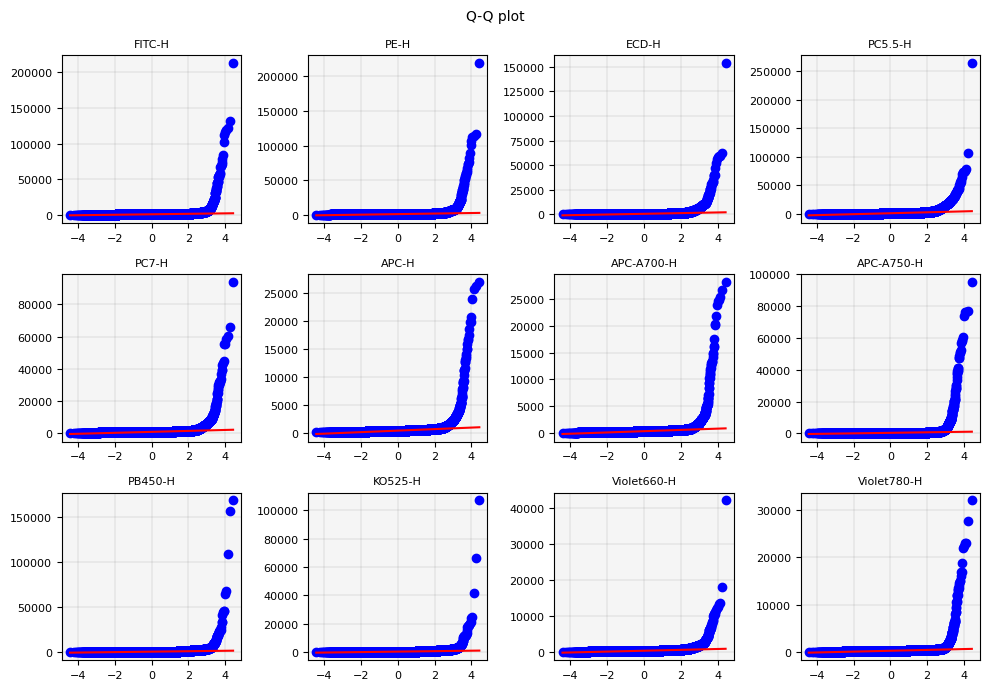

In [ ]:
qqplot(new_opticalH_label)

In [ ]:
# Тест Харке-Бера

for col in new_opticalH_label.iloc[:, :-1].columns:
    jb_stat, jb_p_value = stats.jarque_bera(new_opticalH_label.iloc[:, :-1][col])
    print(f"Столбец: {col} p-значение: {jb_p_value}")

Столбец: FITC-H p-значение: 0.0
Столбец: PE-H p-значение: 0.0
Столбец: ECD-H p-значение: 0.0
Столбец: PC5.5-H p-значение: 0.0
Столбец: PC7-H p-значение: 0.0
Столбец: APC-H p-значение: 0.0
Столбец: APC-A700-H p-значение: 0.0
Столбец: APC-A750-H p-значение: 0.0
Столбец: PB450-H p-значение: 0.0
Столбец: KO525-H p-значение: 0.0
Столбец: Violet660-H p-значение: 0.0
Столбец: Violet780-H p-значение: 0.0


Вывод только из этих трех тестов очевиден: **распределение не является нормальным**. Причем, до критической степени - наблюдается очень большой скос влево при огромных "хвостах". Попробуем хоть немного такое положение дел исправить путем нормализации данных.

- MinMaxScaler (результат так себе)
- PowerTransformer (результат неудачный)
- MaxAbsScaler (результат неудачный)
- Box-Cox (результат так себе)
- Log1p (результат так себе)
- Log10 (результат неудачный)
- Квадратный корень (результат так себе)

Успешные попытки:
- Кубический корень (неплохо)
- log1p + MinMaxScaler (лучше всех остальных вариантов)


In [ ]:
# Log

df_log = np.log1p(df)

In [ ]:
# + MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_log)
df_scaled = pd.DataFrame(data=scaled_data, columns=df.columns)

In [ ]:
# датасет с нормализованными данными

df_scaled.to_csv('/content/drive/MyDrive/DIPLOM/new/new_scaled_norm.csv', index=False)
new_scaled_norm = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_scaled_norm.csv')
new_scaled_norm.head(5)

,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H
0,0.504175,0.395829,0.339163,0.584904,0.430751,0.349737,0.386848,0.452855,0.243122,0.248239,0.532850,0.322010
1,0.461288,0.311417,0.257547,0.487833,0.313745,0.319889,0.272505,0.467622,0.247521,0.136505,0.533493,0.315691
2,0.420755,0.255233,0.224524,0.362875,0.252519,0.307648,0.298265,0.400873,0.104154,0.177275,0.531876,0.296098
3,0.464340,0.345333,0.307128,0.527994,0.307980,0.398900,0.331526,0.382998,0.136360,0.121549,0.563199,0.315152
4,0.470304,0.338071,0.334437,0.541999,0.400649,0.307193,0.291096,0.400090,0.198799,0.208912,0.527879,0.316229


Снова выведем Гистограммы и QQ-plot, чтобы увидеть изменения в распределении.

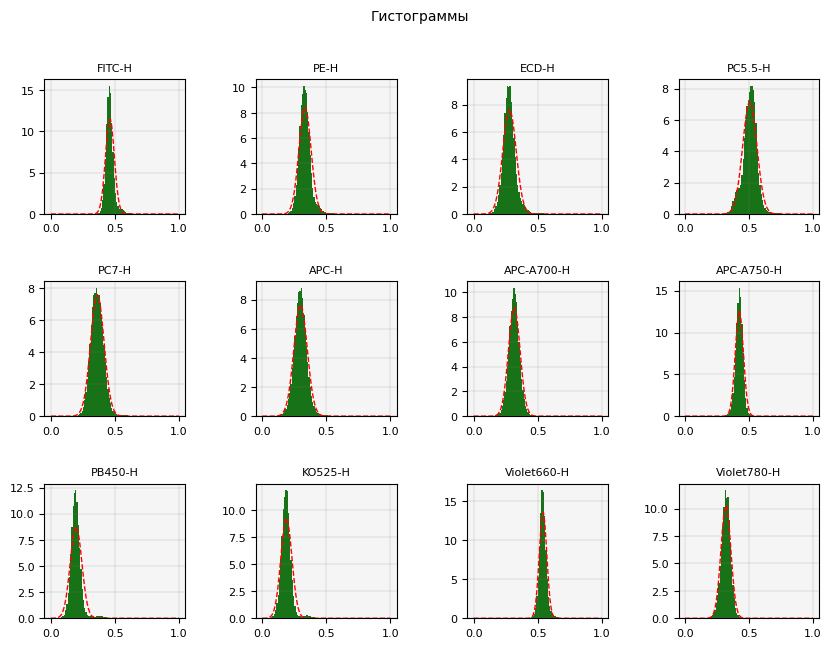

In [ ]:
histt(new_scaled_norm)

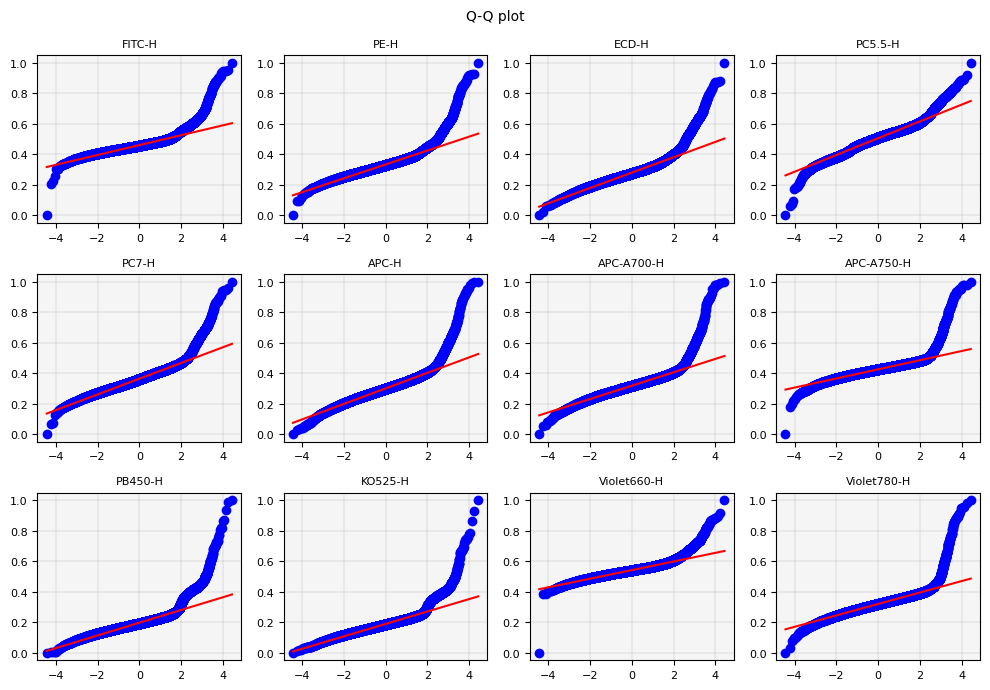

In [ ]:
qqplot(new_scaled_norm)

Полученное распределение все равно не является нормальным, но датасет выглядит гораздо лучше, чем первоначальный его вариант.

Посмотрим KDE нормализованного датасета + разбивку по категориям. Видно, что:

- центры ядер плотности некоторых столбцов практически совпадают, а значит, высокая коллинеарность признаков сохраняется;
- есть сильно вытянутые вверх "колокола", то есть признаки этих категорий концентрируются вокруг относительно небольшого интервала значений;  
- почти у каждой категории в наличии "хвосты", но теперь они расположены не только вправо по распределению (у таких категорий сохраняется  левый перекос), но в обе стороны у тех категорий, которые сместились к центру распределения. При этом правые "хвосты" выражены существеннее левых;
- основную роль в формировании ядра плотности с центром примерно 0.45-0.48, ожидаемо вносят самые большие по размеру категории 'Platelets and Debris' (15 770 элементов) и 'RBC' (129 343 элементов).



In [ ]:
# Возвращаем нормализованному датасету столбец label

new_scaled_norm = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_scaled_norm.csv')
new_opticalH_label = pd.read_csv('/content/drive/MyDrive/DIPLOM/new/new_opticalH_label.csv')
new_scaled_norm_label = new_scaled_norm.merge(new_opticalH_label[['label']], left_index=True, right_index=True)
new_scaled_norm_label.head(5)

,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H,label
0,0.504175,0.395829,0.339163,0.584904,0.430751,0.349737,0.386848,0.452855,0.243122,0.248239,0.532850,0.322010,RBC
1,0.461288,0.311417,0.257547,0.487833,0.313745,0.319889,0.272505,0.467622,0.247521,0.136505,0.533493,0.315691,RBC
2,0.420755,0.255233,0.224524,0.362875,0.252519,0.307648,0.298265,0.400873,0.104154,0.177275,0.531876,0.296098,Platelets and Debris
3,0.464340,0.345333,0.307128,0.527994,0.307980,0.398900,0.331526,0.382998,0.136360,0.121549,0.563199,0.315152,RBC
4,0.470304,0.338071,0.334437,0.541999,0.400649,0.307193,0.291096,0.400090,0.198799,0.208912,0.527879,0.316229,RBC


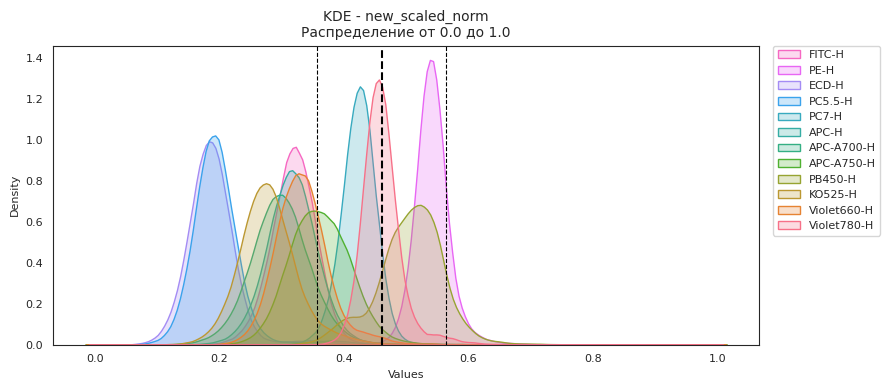

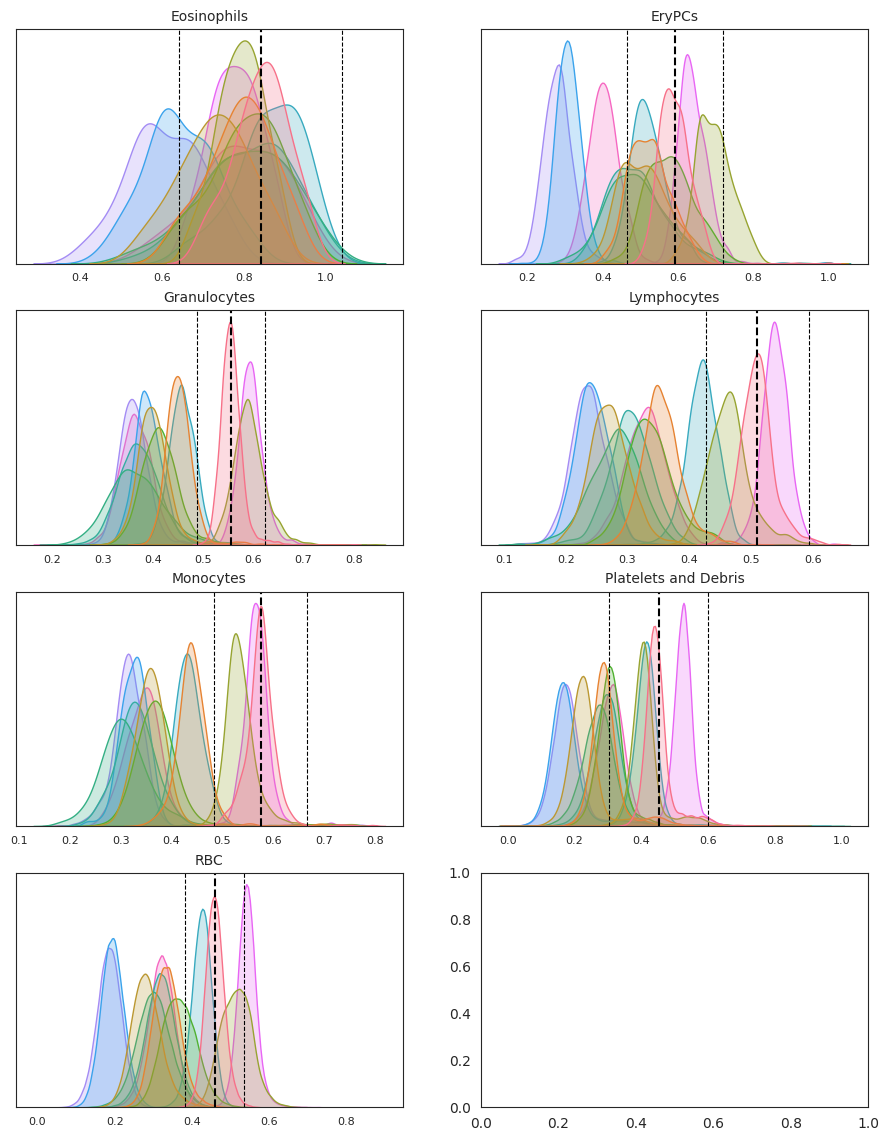

In [ ]:
# Строим KDE

def kde_plot(df1, titles=None):
    num_plots = len(df1)
    max_vals = []
    min_vals = []

    for data in df1:
        max_vals.append(data.values.max())
        min_vals.append(data.values.min())

    fig, ax = plt.subplots(1, num_plots, figsize=(9, 4))
    sns.set_style("white")
    Last_ax = None
    for i, data in enumerate(df1):
        sns.kdeplot(data=data, fill=True, color='skyblue')
        ax.axvline(data.mean().values[0], color='black', linestyle='--')
        ax.axvline(data.mean().values[0] - 3 * data.std().values[0],
                   color='black', linewidth=0.8, linestyle='--')
        ax.axvline(data.mean().values[0] + 3 * data.std().values[0],
                   color='black', linewidth=0.8, linestyle='--')
        minn = round(min_vals[i], 2)
        maxx = round(max_vals[i], 2)
        ax.set_title(f'KDE - {titles[i]}\nРаспределение от {minn} до {maxx}', fontsize=10)
        if i == 0:
            ax.set_ylabel("Density", fontsize=8)
            ax.set_xlabel("Values", fontsize=8)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.legend_.remove()
    if i == num_plots - 1:
        ax.legend(bbox_to_anchor=(1.02, 1), labels=df1[0].columns.tolist(),
                  loc='upper left', borderaxespad=0, fontsize=8)
    plt.tight_layout()

def kde_categor(df2, label_col):
    groups = df2.groupby(label_col)
    num_plots = len(groups)
    max_vals = []
    min_vals = []
    for _, group in groups:
        max_vals.append(group.max().max())
        min_vals.append(group.min().min())
    labels = ['Eosinophils', 'EryPCs', 'Granulocytes', 'Lymphocytes', 'Monocytes', 'Platelets and Debris', 'RBC']
    columns = df2.columns.tolist()
    df2['label'].replace({0.0: 'Eosinophils', 1.0: 'EryPCs', 2.0: 'Granulocytes',
                          3.0: 'Lymphocytes', 4.0: 'Monocytes',
                          5.0: 'Platelets and Debris', 6.0: 'RBC'}, inplace=True)

    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 14))
    for i in range(len(labels)):
        row = i // 2
        col = i % 2
        sns.kdeplot(data=df2[df2['label']==labels[i]].iloc[:,:-1], fill=True,
                    common_norm=False, ax=axes[row, col], legend=False)
        axes[row, col].axvline(df2[df2['label']==labels[i]].iloc[:,:-1].mean().values[0],
                               color='black', linestyle='--')
        axes[row, col].axvline(df2[df2['label']==labels[i]].iloc[:,:-1].mean().values[0]
                               - 3 * df2[df2['label']==labels[i]].iloc[:,:-1].std().values[0],
                               color='black', linewidth=0.8, linestyle='--')
        axes[row, col].axvline(df2[df2['label']==labels[i]].iloc[:,:-1].mean().values[0]
                               + 3 * df2[df2['label']==labels[i]].iloc[:,:-1].std().values[0],
                               color='black', linewidth=0.8, linestyle='--')
        axes[row, col].set_title(labels[i], fontsize=10)
        axes[row, col].tick_params(axis='x', labelsize=8)
        axes[row, col].set_ylabel('')
        axes[row, col].set_yticklabels([])

def kde_two(df1, df2, label_col, titles):
    kde_plot(df1, titles)
    kde_categor(df2, label_col)
    plt.show()

kde_two([new_scaled_norm], new_scaled_norm, 'label', titles=['new_scaled_norm'])

В качестве логического завершения этого кода обучим на датасете простой автокодировщик - **Undercomplete Autoencoder** и визуализируем после энкодера скрытое пространство (из почти трети датасета, ибо из полного будет очень долго). Но этого вполне достаточно, чтобы увидеть закономерности.

In [ ]:
# Заменяем категории в столбце label на цифровые обозначения

new_scaled_norm_label = new_scaled_norm.merge(new_scaled_norm_label[['label']], left_index=True, right_index=True)
le = LabelEncoder()
new_scaled_norm_label['label'] = le.fit_transform(new_scaled_norm_label['label'])

In [ ]:
new_scaled_norm_label.to_csv('/content/drive/MyDrive/DIPLOM/COLAB_2/new_scaled_norm_lab.csv', index=False)
new_scaled_norm_lab = pd.read_csv('/content/drive/MyDrive/DIPLOM/COLAB_2/new_scaled_norm_lab.csv')
new_scaled_norm_lab.head(5)

,FITC-H,PE-H,ECD-H,PC5.5-H,PC7-H,APC-H,APC-A700-H,APC-A750-H,PB450-H,KO525-H,Violet660-H,Violet780-H,label
0,0.504175,0.395829,0.339163,0.584904,0.430751,0.349737,0.386848,0.452855,0.243122,0.248239,0.532850,0.322010,6
1,0.461288,0.311417,0.257547,0.487833,0.313745,0.319889,0.272505,0.467622,0.247521,0.136505,0.533493,0.315691,6
2,0.420755,0.255233,0.224524,0.362875,0.252519,0.307648,0.298265,0.400873,0.104154,0.177275,0.531876,0.296098,5
3,0.464340,0.345333,0.307128,0.527994,0.307980,0.398900,0.331526,0.382998,0.136360,0.121549,0.563199,0.315152,6
4,0.470304,0.338071,0.334437,0.541999,0.400649,0.307193,0.291096,0.400090,0.198799,0.208912,0.527879,0.316229,6


Выделим из датасета ***как бы*** тестовую выборку. Мне она нужна только для визуализации латентного пространства, поэтому я ставлю test_size=0.3. В случае с реальным обучением автокодировщика это многовато (хотя все зависит от целей обучения).

In [ ]:
# Выделяем из датасета как бы тестовую выборку

X = new_scaled_norm_lab.drop('label', axis=1)
y = new_scaled_norm_lab['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, X_train.ndim, type(X_train))
print(X_test.shape, X_test.ndim, type(X_test))
print(y_train.shape, y_train.ndim, type(y_train))
print(y_test.shape, y_test.ndim, type(y_test))

(105000, 12) 2 <class 'pandas.core.frame.DataFrame'>
(45000, 12) 2 <class 'pandas.core.frame.DataFrame'>
(105000,) 1 <class 'pandas.core.series.Series'>
(45000,) 1 <class 'pandas.core.series.Series'>


In [ ]:
X_train = X_train.values.reshape(-1, 12)
print(X_train.shape, X_train.ndim, type(X_train))
y_train = y_train.values.reshape(-1, 1)
print(y_train.shape, y_train.ndim, type(y_train))

(105000, 12) 2 <class 'numpy.ndarray'>
(105000, 1) 2 <class 'numpy.ndarray'>


In [ ]:
X_test = X_test.values.reshape(-1, 12) # превращаем в двухмерность
print(X_test.shape, X_test.ndim, type(X_test))
y_test = y_test.values.reshape(-1, 1)
print(y_test.shape, y_test.ndim, type(y_test))

(45000, 12) 2 <class 'numpy.ndarray'>
(45000, 1) 2 <class 'numpy.ndarray'>


In [ ]:
# Undercomplete Autoencoder
# ====================================================

input = Input(shape=(12,))
encoded = Dense(6, activation='relu')(input)
decoded = Dense(12, activation='sigmoid')(encoded)

auto_undercomp = Model(input, decoded)
auto_undercomp.compile(optimizer='adam', loss='mse')

history = auto_undercomp.fit(X_train, X_train, epochs=20, batch_size=128,
                shuffle=True, verbose=1, validation_data=(X_test, X_test))

encoder = Model(input, encoded)
x_train_encoded = encoder.predict(X_train)

Epoch 1/20
821/821 [==============================] - 7s 4ms/step - loss: 0.0087 - val_loss: 0.0024
Epoch 2/20
821/821 [==============================] - 3s 3ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/20
821/821 [==============================] - 2s 3ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/20
821/821 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 8.9887e-04
Epoch 5/20
821/821 [==============================] - 2s 3ms/step - loss: 8.3955e-04 - val_loss: 7.9528e-04
Epoch 6/20
821/821 [==============================] - 4s 5ms/step - loss: 7.7137e-04 - val_loss: 7.4170e-04
Epoch 7/20
821/821 [==============================] - 3s 3ms/step - loss: 7.1857e-04 - val_loss: 6.8880e-04
Epoch 8/20
821/821 [==============================] - 2s 3ms/step - loss: 6.6454e-04 - val_loss: 6.3450e-04
Epoch 9/20
821/821 [==============================] - 2s 3ms/step - loss: 6.1327e-04 - val_loss: 5.8647e-04
Epoch 10/20
821/821 [==============================] - 4

In [ ]:
auto_undercomp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense (Dense)               (None, 6)                 78        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
Total params: 162 (648.00 Byte)
Trainable params: 162 (648.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


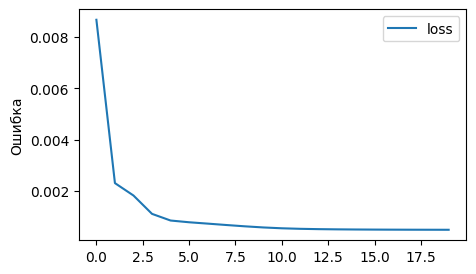

In [ ]:
plt.subplots(figsize=(5, 3))
plt.plot(history.history['loss'], label='loss')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
encoder = tensorflow.keras.models.Model(inputs=auto_undercomp.get_layer('input_1').input, outputs=auto_undercomp.get_layer('dense_1').output)

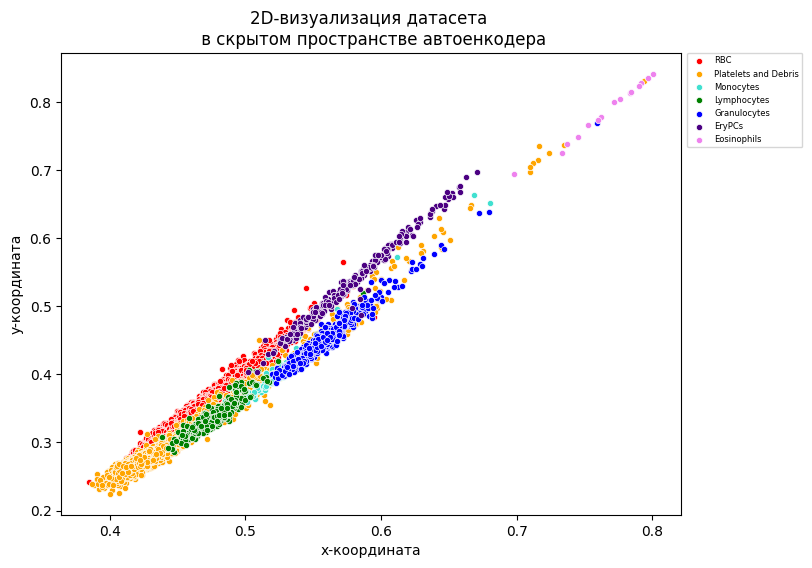

In [ ]:
def latent_sp(datas):
  # Перенаправление stdout в os.devnull
  sys.stdout = open(os.devnull, 'w')

  label_dict = {0: 'Eosinophils', 1: 'EryPCs', 2: 'Granulocytes', 3: 'Lymphocytes', 4: 'Monocytes', 5: 'Platelets and Debris', 6: 'RBC'}

  x = []
  y = []
  z = []
  for i in range(45000):
      j = i + 1
      z.append(y_test[i])
      op = encoder.predict(np.array([X_test[i]]))
      x.append(op[0][0])
      y.append(op[0][1])

  df = pd.DataFrame()
  df['x'] = x
  df['y'] = y
  df['z'] = [label_dict[k.item()] for k in z]

  # Восстановление stdout после выполнения кода
  sys.stdout = sys.__stdout__
  plt.ioff()  # Turn off interactive mode

  categories = df['z'].sort_values(ascending=False).unique() # это категории от 6 до 0 сверху вниз

  plt.figure(figsize=(8, 6))
  colors = ['red', 'orange', 'turquoise', 'green', 'blue', 'indigo', 'violet']
  for i, category in enumerate(categories):
      x = df[df['z'] == category]['x']
      y = df[df['z'] == category]['y']
      plt.scatter(x, y, color=colors[i], s=20, linewidth=0.5, marker='o', edgecolor='white', label=category)

  plt.xlabel('x-координата')
  plt.ylabel('y-координата')
  plt.title('2D-визуализация датасета \n в скрытом пространстве автоенкодера')
  plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=6, ncol=1)
  plt.show()
latent_sp(x_train_encoded)

**ВЫВОДЫ**

Латентное пространство признаков построено из 45 тыс элементов, тогда как в датасете 150 тыс элементов.

- Пространственное расположение категорий сохранилось и в латентном пространстве, что видно по трем классам Monocytes, Granulocytes и Lymphocytes

- Самые большие по количеству элементов категории расположились по центру распределения, как это и отражено на графиках KDE

- Снова наблюдается высокая корреляция между признаками категорий - "лучи" плотно прижаты друг к другу

- На прочную межпризнаковую связь указывает небольшой угол расхождения "лучей" (чем угол расхождение больше, тем связь менее прочная).

В целом можно сказать, что автоенкодер неплохо реконструировал признаки в сжатом латентном пространстве.